In [1]:
import utilities
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from scipy import signal

## Cross correlation for 1D arrays

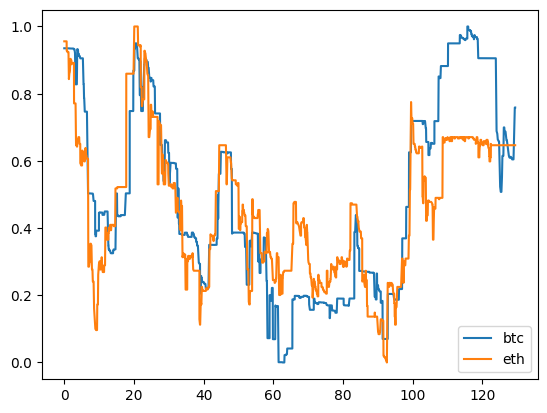

In [2]:
### PARAMETERS
products = ["btc", "eth"]
col_to_plot = "ask_price_min"
###

data_path = utilities.get_data_path(tree_level=2)
filenames = {}
dataframes = {}
scalers = {}

fig, ax = plt.subplots()

for product in products:
    filenames[product] = os.path.join(data_path, "datasets", f"{product}_stats_aligned.csv")
    dataframes[product] = pd.read_csv(filenames[product], index_col=0)

    # Normalize
    scalers[product] = MinMaxScaler()
    dataframes[product] = pd.DataFrame(scalers[product].fit_transform(dataframes[product]),
                                       columns=dataframes[product].columns,
                                       index=dataframes[product].index)
    
    time = dataframes[product].index
    ax.plot(time, dataframes[product][col_to_plot], label=product)

x1 = dataframes[products[0]]
x2 = dataframes[products[1]]

plt.legend()
plt.show()

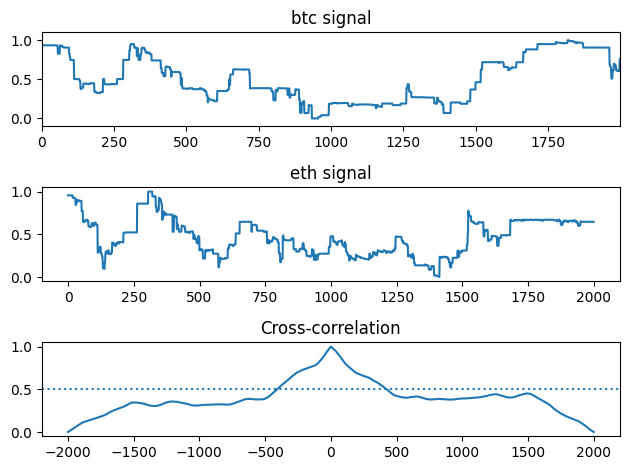

In [3]:
x1_1d = dataframes[products[0]][col_to_plot].values
x2_1d = dataframes[products[1]][col_to_plot].values

corr = signal.correlate(x1_1d, x2_1d)
lags = signal.correlation_lags(len(x1_1d), len(x2_1d))
corr /= np.max(corr)

fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1)

ax_orig.plot(x1_1d)
ax_orig.set_title(f"{products[0]} signal")
ax_noise.plot(x2_1d)
ax_noise.set_title(f"{products[1]} signal")
ax_corr.plot(lags, corr)
ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Cross-correlation')
ax_orig.margins(0, 0.1)
fig.tight_layout()
plt.show()

## Cross correlation for windowed arrays

In [4]:
def sliding_window_cross_correlation(x1, x2, window_size, step_size):
    # Initialize an empty list to store lags
    all_lags = []

    # Iterate through the data using non-overlapping sliding windows
    for i in range(0, len(x1) - window_size + 1, step_size):
        window_x1 = x1[i : i + window_size]
        window_x2 = x2[i : i + window_size]

        # Compute cross-correlation for the current window
        corr = signal.correlate(window_x1, window_x2)
        max_lag = np.argmax(np.abs(corr)) - len(window_x1) + 1
        # lags = signal.correlation_lags(len(x1), len(x2))
        # corr /= np.max(corr)

        # Store the lag for this window
        all_lags.append(max_lag)

    # Calculate the average lag
    average_lag = np.mean(all_lags)
    return average_lag, all_lags

window_size = 100 
step_size = 10
average_lag, all_lags = sliding_window_cross_correlation(x1_1d, x2_1d, window_size, step_size)
print(f"Average lag (non-overlapping windows): {average_lag} samples")

Average lag (non-overlapping windows): 0.17801047120418848 samples


In [5]:
min_window_start = int(np.argmin(all_lags) * step_size)
print(f"Lowest value for window: {min_window_start} to {min_window_start + window_size}")
max_window_start = int(np.argmax(all_lags) * step_size)
print(f"Lowest value for window: {max_window_start} to {max_window_start + window_size}")

Lowest value for window: 800 to 900
Lowest value for window: 1240 to 1340


In [ ]:
plt.plot(all_lags)
plt.show()

In [ ]:
fig, (ax_orig, ax_noise) = plt.subplots(2, 1)

ax_orig.plot(x1_1d[min_window_start : min_window_start + window_size])
ax_orig.set_title(f"{products[0]} signal")
ax_noise.plot(x2_1d[min_window_start : min_window_start + window_size])
ax_noise.set_title(f"{products[1]} signal")
fig.tight_layout()
plt.show()

In [ ]:
fig, (ax_orig, ax_noise) = plt.subplots(2, 1)

ax_orig.plot(x1_1d[max_window_start : max_window_start + window_size])
ax_orig.set_title(f"{products[0]} signal")
ax_noise.plot(x2_1d[max_window_start : max_window_start + window_size])
ax_noise.set_title(f"{products[1]} signal")
fig.tight_layout()
plt.show()

## Cross correlation for 2D+ arrays

In [9]:
x1.head()

,bid_price_min,bid_price_q1,bid_price_median,bid_price_q3,bid_price_max,bid_price_mean,bid_price_std,ask_price_min,ask_price_q1,ask_price_median,...,ask_vol_price_q3,ask_vol_price_max,ask_vol_price_mean,ask_vol_price_std,spread_min,spread_btwn_means,spread_btwn_medians,spread_btwn_vol_sums,spread_btwn_vol_means,spread_btwn_vol_medians
time,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,0.446883,0.224475,0.383462,0.93969,0.392486,0.667518,0.935095,0.340638,0.370923,...,0.321474,0.0,0.509244,0.513563,0.191441,0.512763,0.444231,0.368517,0.505109,0.87581
0.028059,0.0,0.446883,0.224475,0.383462,0.93969,0.392486,0.667518,0.935095,0.340638,0.370923,...,0.321474,0.0,0.509244,0.513563,0.191441,0.512763,0.444231,0.368517,0.505109,0.87581
0.057995,0.0,0.446883,0.224475,0.383462,0.93969,0.392486,0.667518,0.935095,0.340638,0.370923,...,0.321474,0.0,0.509244,0.513563,0.191441,0.512763,0.444231,0.368517,0.505109,0.87581
0.069528,0.0,0.443613,0.185324,0.357609,0.93969,0.368115,0.631989,0.935095,0.331625,0.367804,...,0.320545,0.0,0.493845,0.498411,0.191441,0.497967,0.458623,0.369948,0.489557,0.87979
0.130339,0.0,0.443613,0.185324,0.357609,0.93969,0.368115,0.631989,0.935095,0.331625,0.367804,...,0.320545,0.0,0.493845,0.498411,0.191441,0.497967,0.458623,0.369948,0.489557,0.87979


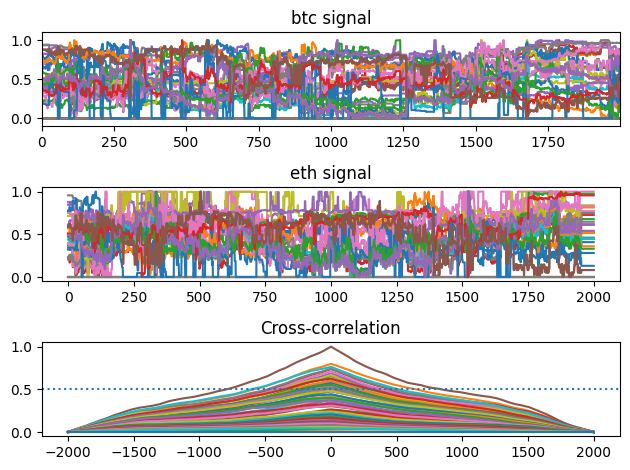

In [10]:
# _nd stands for n-dimensional
x1_nd = x1.values
x2_nd = x2.values

corr = signal.correlate(x1_nd, x2_nd)
lags = signal.correlation_lags(len(x1_nd), len(x2_nd))
corr /= np.max(corr)

fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1)

ax_orig.plot(x1_nd)
ax_orig.set_title(f"{products[0]} signal")
ax_noise.plot(x2_nd)
ax_noise.set_title(f"{products[1]} signal")
ax_corr.plot(lags, corr)
ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Cross-correlation')
ax_orig.margins(0, 0.1)
fig.tight_layout()
plt.show()

In [14]:
window_size = 100 
step_size = 10
average_lag, all_lags = sliding_window_cross_correlation(x1_nd, x2_nd, window_size, step_size)
print(f"Average lag (non-overlapping windows): {average_lag} samples")

Average lag (non-overlapping windows): 6965.0 samples


In [13]:
all_lags

[6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,
 6965,